In [2]:
!pip install d2l
!pip install matplotlib==3.0.2

     |████████████████████████████████| 82 kB 545 kB/s 
     |████████████████████████████████| 9.9 MB 40.0 MB/s 
     |████████████████████████████████| 11.2 MB 61.4 MB/s 
     |████████████████████████████████| 61 kB 7.1 MB/s 
     |████████████████████████████████| 900 kB 46.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you h

     |████████████████████████████████| 12.9 MB 14.5 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
d2l 0.17.5 requires matplotlib==3.5.1, but you have matplotlib 3.0.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## Dropout in Practice

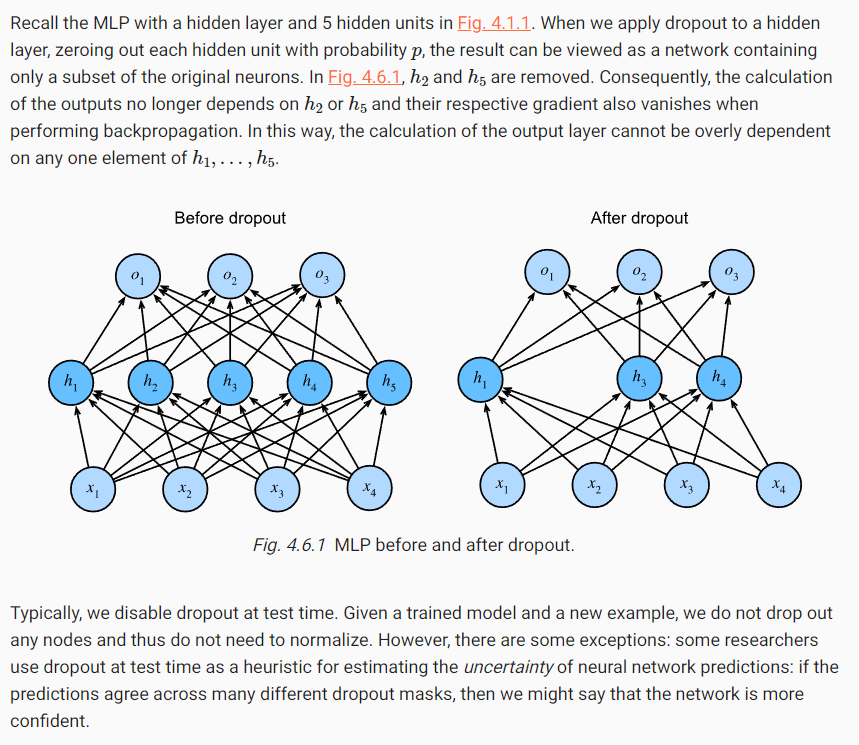

## Implementation from Scratch

Untuk mengimplemperasikan fungsi dropout untuk satu layer, kita harus menggambar sebanyak mungkin sampel dari variabel acak Bernoulli (biner) karena layernya memiliki dimensi, di mana variabel acak membutuhkan nilai (keep) dengan probabilitas *1-p* dan *0* (drop) dengan probabilitas *p*.

Satu **cara** mudah u**ntuk mengimplementasikan** ini adalah untuk menggambar sampel pertama dari distribusi yang seragam. Maka kita dapat menjaga node-node itu untuk sampel yang sesuai lebih besar daripada, menjatuhkan sisanya.

Dengan kode ini, dapat diterapkan fungsi dropout_layer yang menjatuhkan elemen-elemen pada input tensor **X** dengan probability dropout, rescaling sisanya seperti dijelaskan di atas: Membagi survivors dengan 1,0-dropout.

In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # In this case, all elements are dropped out
    if dropout == 1:
        return torch.zeros_like(X)
    # In this case, all elements are kept
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

Kami dapat menguji fungsi dropout_layer pada beberapa contoh. Dalam baris kode berikut, kami melewati input **X** kami melalui operasi dropout, **dengan probabilitas 0, 0,5, dan 1**, masing-masing.

In [2]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  0.,  4.,  0.,  0.,  0., 12., 14.],
        [16., 18., 20., 22., 24., 26.,  0.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


### Defining Model Parameters

Dengan data Fashion-MNIST. Dapat didefinisikan MLP dengan dua layer tersembunyi masing-masing masing-masing 256 unit.

In [3]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

### Defining the Model

Model di bawah ini menerapkan dropout ke output setiap hidden layer (mengikuti fungsi aktivasi). Kami dapat mengatur probabilitas dropout untuk setiap lapisan secara terpisah. Tren umum adalah untuk menetapkan probabilitas dropout yang lebih rendah lebih dekat ke lapisan input.

**Contoh** dibawah ini diatur menjadi 0,2 dan 0,5 untuk hidden layer pertama dan kedua. 

*Kami memastikan bahwa dropout hanya aktif selama pelatihan.*

In [4]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # Use dropout only when training the model
        if self.training == True:
            # Add a dropout layer after the first fully connected layer
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # Add a dropout layer after the second fully connected layer
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

### Training and Testing

Ini mirip dengan pelatihan dan pengujian MLPS yang dijelaskan sebelumnya.

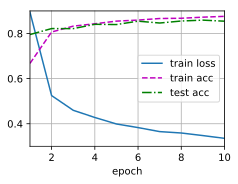

In [5]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## Concise Implementation

Dengan API tingkat tinggi, yang perlu kita lakukan adalah menambahkan lapisan dropout setelah setiap lapisan yang sepenuhnya terhubung, melewati probabilitas dropout sebagai satu-satunya argumen untuk konstruktornya. Selama pelatihan, layer dropout akan secara acak melepaskan output dari layer sebelumnya (atau setara, input ke layer berikutnya) sesuai dengan probabilitas dropout yang ditentukan. Saat tidak dalam mode pelatihan, layer dropout hanya melewati data selama pengujian.

In [7]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # Add a dropout layer after the first fully connected layer
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # Add a dropout layer after the second fully connected layer
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

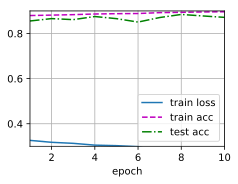

In [6]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## Summary



*   Selain mengendalikan jumlah dimensi dan ukuran vektor berat, dropout adalah alat lain untuk menghindari overfitting. Seringkali mereka digunakan bersama.

*   Dropout menggantikan aktivasi ***h*** dengan variabel acak dengan nilai yang diharapkan ***h***.
*   Dropout hanya digunakan selama pelatihan.


